In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
import pickle
import seaborn as sns
import multiprocessing
os.environ["PYTHONWARNINGS"] = 'ignore'# 'ignore::sklearn.exceptions.ConvergenceWarning:sklearn.model_selection.GridSearchCV'
#os.environ["OMP_NUM_THREADS"] = 1

In [2]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import re

In [3]:
# dask cluster location
cluster_loc = 'hpc'
prefix = 'transect'
logo_group = 'Year'
tuneby = 'year'
use_cuda = False

inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_' + prefix + '_hls_idxs.csv'
inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'
outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + logo_group + '_tuneby_' + tuneby + '_tmp.csv', inFILE))

date_col = 'Date'
y_col = 'Biomass_kg_ha'

var_names = [
    'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 'SAVI',
    'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
    'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346',
    'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2'
]

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

var_dv1 = ['NDVI', 'NDII7', 'SAVI', 'RDVI', 'MTVI1', 'PSRI', 'NDWI', 'EVI', 'TCGI']

include_dv1 = False

if prefix == 'transect':
    batch_size = 256
elif prefix == 'plot':
    batch_size = 64

In [4]:
import psutil
interface_prefs = ['enp24s0f0', 'ens7f0']
interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
if len(interface) == 0:
    print('ERROR: Preferred interfaces not found on node!')
else:
    print(interface)

enp24s0f0


In [5]:
if cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='brief-low', #'scavenger-gpu',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            project='cper_neon_aop',
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory='12GB',
                            #interface='ib0',
                            #interface='ens7f0',
                            #interface='enp1s0f0',
                            scheduler_options={'interface': interface},
                            local_directory='$TMPDIR',
                            death_timeout=120,
                            walltime='01:00:00',
                            job_extra_directives=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=44
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes*0.1, timeout=60)
    except dask.distributed.TimeoutError as e:
        print('workers may not be available. Diplaying client with currently available workers.')
        #print(e)
        pass
    display(client)
    backend = 'dask'
else:
    backend = 'threading'

   setting up cluster on HPC...


<Client: 'tcp://10.1.4.120:41855' processes=18 threads=36, memory=50.22 GiB>

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
#from xgboost import XGBRegressor

if backend == 'dask':
    #from dask_ml.xgboost import XGBRegressor
    from dask_ml.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
else:
    #from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch

In [8]:
#import sys
#sys.path.insert(0, '/project/cper_neon_aop/cper_hls_veg_models/models/dnn_architectures')

#import dnn

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

In [10]:
#df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
#df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [11]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
#df_vor = df_vor.rename(columns=var_dict)

In [12]:
if 'dvi' in inFILE:
    if include_dv1:
        for i in var_dv1:
            var_dict[i + '_dv1'] = var_dict[i] + '_dv1'
            var_names.append(var_dict[i] + '_dv1')
    else:
        df_vor = df_vor.drop(columns=[i + '_dv1' for i in var_dv1])

In [13]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [14]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [15]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [16]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

In [17]:
if False:
    sns.displot(x='Biomass_kg_ha', col='Year', col_wrap=3, hue='Season', data=df_vor, height=3, aspect=1.5)

In [18]:
if False:
    g = sns.lmplot(x='tcwi', y='Biomass_kg_ha', scatter=True, hue='Pasture', ci=None, data=df_vor)
    g.set(yscale="log")

In [19]:
if False:
    corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
    plt.figure(figsize=(14, 12))
    plt.suptitle('All')
    sns.heatmap(corrMatrix, annot=True)
    #plt.show()

In [20]:
if False:
    fig, axs = plt.subplots(figsize=(16, 20),
                            nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
    for idx, v in enumerate(var_names):
        xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
        z_bm = gaussian_kde(xy_bm)(xy_bm)
        df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                                c=z_bm, cmap='magma', colorbar=False)
        plt.tight_layout(pad=1.0)

In [21]:
if backend == 'dask':
    nthreads = len(client.nthreads())
else:
    nthreads = multiprocessing.cpu_count()
print(nthreads)

176


In [22]:
torch.cuda.device_count()

0

In [23]:
if torch.has_cuda and use_cuda:
    device='cuda'
else:
    device='cpu'
print(device)

cpu


In [24]:
#device = 'cpu'
#print(device)

In [25]:
# Build resnet from scratch for regression, replacing convolutions and pooling with dense layers
# adapted from https://www.mdpi.com/1099-4300/24/7/876
# adapted from https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = None):
        super(ResidualBlock, self).__init__()
        self.dense1 = nn.Sequential(
                        nn.Linear(in_channels, out_channels, bias=False),
                        nn.BatchNorm1d(out_channels),
                        nn.ReLU())
        self.dense2 = nn.Sequential(
                        nn.Linear(out_channels, out_channels, bias=False),
                        nn.BatchNorm1d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.dense1(x)
        out = self.dense2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNetRegressor(nn.Module):
    def __init__(self, block, layers, n_inputs=1):
        super(ResNetRegressor, self).__init__()
        self.inplanes = 64
        self.dense1 = nn.Sequential(
                        nn.Linear(n_inputs, 64, bias=False),
                        nn.BatchNorm1d(64),
                        nn.ReLU())
        #self.maxpool = nn.MaxPool1d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0])
        self.layer1 = self._make_layer(block, 128, layers[1])
        self.layer2 = self._make_layer(block, 256, layers[2])
        self.layer3 = self._make_layer(block, 512, layers[3])
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 1)
        
    def _make_layer(self, block, planes, blocks):
        downsample = None
        if self.inplanes != planes:   
            downsample = nn.Sequential(
                nn.Linear(self.inplanes, planes, bias=False),
                nn.BatchNorm1d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.dense1(x)
        #x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [26]:
from torch import Tensor
from torch.nn.modules.loss import _Loss
class MAPELoss(_Loss):
    r"""Creates a criterion that measures the mean absolute percent error (MAPE) between each element in
    the input :math:`x` and target :math:`y`.

    Args:
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there are multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when :attr:`reduce` is ``False``. Default: ``True``
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Target: :math:`(*)`, same shape as the input.
        - Output: scalar. If :attr:`reduction` is ``'none'``, then
          :math:`(*)`, same shape as the input.
    """
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        if self.reduction == 'mean':
            return torch.mean(abs((input - target)/target))
        elif self.reduction == 'sum':
            return torch.sum(abs((input - target)/target))
        else:
            print('ERROR: Invalid reduction. Must be one of "mean" or "sum".')

rnr = NeuralNetRegressor(
    ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
    criterion=nn.L1Loss,
    optimizer=optim.SGD,
    lr=0.001,
    max_epochs=100,
    batch_size=128,
    train_split=skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.EarlyStopping(patience=10, load_best=True)],
    verbose=0, 
    device=device
)

In [27]:
mod_dict = {
    'CPER_2022': {
        'base_mod': lr_mod,
        'fit': True,
        'tune': False,
        'tune_refit': None,
        'tune_refit_type': None,
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
    },
    'OLS_2022': {
        'base_mod': y_col + ' ~ NDII7 + NIR1 + BAI_236 + NDII7:NIR1 + NDII7:BAI_236 + NIR1:BAI_236',
        'fit': True,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
    },
    'OLS': {
        'base_mod': y_col + ' ~ ',
        'fit': True,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'formula_df': pd.DataFrame(columns=['kfold', 'kfold_name', 'numb_vars', 'formula', 'R2_adj', 'AIC', 'mae_orig_mean'])
    },
    'LASSO': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('LASSO', Lasso())
            ]),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'LASSO__alpha': np.logspace(-3, 1, num=30)
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable', 'Coef'])
    },
    'PLS': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('PLS', PLSRegression(n_components=1, scale=False))
            ]),
        'fit': True,
        'tune': True,
        'tune_vip': False,
        'tune_vip_iters': 3,
        'tune_vip_thresh': [0.8, 0.8, 0.8],
        'variable_importance': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'PLS__n_components': [int(x) for x in np.arange(1, len(var_names)*0.5)]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable', 'VIP', 'Coef'])
    },
    'PCR': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('pca', PCA()), 
                ('linreg', LinearRegression())
            ]),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'pca__n_components': [int(x) for x in np.arange(1, len(var_names)*0.5)]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable'] + ['PC_' + str(i+1) for i in range(len(var_names))])
    },
    'SVR': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('SVR', SVR(kernel='linear'))
            ]),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'SVR__C': np.logspace(1.5, 4, 10, base=10),
            'SVR__gamma': np.logspace(-3.5, 0, 10, base=10)
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable', 'SVR_weights'])
    },
    'RF': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('RF', RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, n_jobs=-1))
            ]),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'RF__min_samples_split': [0.0001, 0.001, 0.005, 0.01],
            #'n_estimators': [400],
            'RF__max_samples': [0.2, 0.3, 0.5, 0.7, 0.9],
            'RF__max_features': [0.1, 0.25, 0.5, 0.75, 1.0]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable', 'MDI'])
    },
    'GBR': {
        #'base_mod': XGBRegressor(n_jobs=-1, verbosity=0),
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('GBR', GradientBoostingRegressor(loss='absolute_error'))
            ]),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'GBR__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
            'GBR__min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
            'GBR__n_estimators': [100, 200, 400, 600, 800],
            'GBR__max_features': [0.1, 0.25, 0.5]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['kfold', 'Variable', 'MDI'])
    },
    'MLP': {
        'base_mod': MLPRegressor(solver='adam', activation='logistic', hidden_layer_sizes=(256,),
                                 max_iter=1000, learning_rate='adaptive'),
        'fit': False,
        'variable_importance': False,
        'tune': False,
        'tune_refit': 'MAE',
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (150,)],
            'alpha': [0.00005, 0.0001, 0.0005, 0.001]
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
    },
    'DNN': {
        'base_mod': rnr,
        'fit': False,
        'variable_importance': False,
        'tune': True,
        'tune_refit': 'MAE',
        'param_grid': {
            'module__block': [ResidualBlock],
            'module__layers': [[3, 4, 6, 3]], 
            'module__n_inputs': [len(var_names)],
            'optimizer__momentum': [0.75, 0.85, 0.95],
            'optimizer__weight_decay': [1e-2, 1e-4],
            'optimizer__nesterov': [True],
            'lr': [0.01, 0.001, 0.0001],
            'batch_size': [batch_size],
            'max_epochs': [100],
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': MinMaxScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
}
}

In [28]:
if backend == 'dask':
    import dask
    @dask.delayed
    def fit_ols(all_x, split_groups, df_train, lr_form, group_k, idx):
        r2_adj_tmp = []
        aic_tmp = []
        mae_orig_tmp = []
        for train_index_sub, test_index_sub in mod_logo.split(all_x, groups=split_groups):
            df_train_sub = df_train.iloc[train_index_sub]
            df_test_sub = df_train.iloc[test_index_sub]
            lreg_k_tmp = smf.ols(formula=lr_form, data=df_train_sub).fit()
            r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
            aic_tmp.append(lreg_k_tmp.aic)
            mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test_sub) - df_test_sub[y_col])))
        df_results_tmp = pd.DataFrame(dict(kfold=[group_k],
                                           kfold_name=[logo_group],
                                           numb_vars=[k_fold],
                                           formula=[lr_form],
                                           R2_adj=round(np.mean(r2_adj_tmp), 4),
                                           AIC=round(np.mean(aic_tmp), 4),
                                           mae_orig_mean=round(np.mean(mae_orig_tmp), 4)),
                                     index=[idx])
        return df_results_tmp

    @dask.delayed
    def fit_dnn(mod_base, batch_start, batch_size, all_x, all_y, loss_fn, optimizer):
        for start in batch_start:
            # take a batch
            X_batch = all_x[start:start+mod_dict[k]['batch_size']]
            y_batch = all_y[start:start+mod_dict[k]['batch_size']]
            # forward pass
            y_pred = mod_base(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        return mod_base

In [29]:
if os.path.exists(outFILE_tmp):
    df_vor = pd.read_csv(outFILE_tmp, parse_dates=[2, 3])
    with open(os.path.join(outDIR, 'tmp', 'ml_train_' + prefix + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'rb') as f:
        mod_dict = pickle.load(f)
else:
    for k in mod_dict:
        if mod_dict[k]['fit']:
            df_vor[k] = np.nan

mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
if logo_group == 'Year':
    mod_split = mod_logo
elif logo_group == 'Pasture':
    mod_split = mod_groupk
    kfold = 0
    df_vor['kfold'] = np.nan
    
scoring = {'R2': 'r2',
           'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error',
           'MAPE': 'neg_mean_absolute_percentage_error',
          }

restart_dask = False

for train_index, test_index in mod_logo.split(df_vor[var_names], groups=df_vor[logo_group]):
    logo_test = df_vor[logo_group].iloc[test_index].unique()
    if logo_group == 'Year':
        logo_k = logo_test[0]
    elif logo_group == 'Pasture':
        kfold += 1
        logo_k = 'kfold' + str(kfold)
        
    print(logo_k)
    
    train_loc = df_vor.iloc[train_index].index
    test_loc = df_vor.iloc[test_index].index
    
    all_y_orig = df_vor['Biomass_kg_ha'].iloc[train_index]
    all_Y_orig = df_vor['Biomass_kg_ha'].iloc[test_index]
    all_x_orig = df_vor[var_names].iloc[train_index, :]
    all_X_orig = df_vor[var_names].iloc[test_index, :]

    for k in mod_dict:
        if mod_dict[k]['fit']:
            if df_vor[df_vor[logo_group].isin(logo_test)][k].isnull().all():
                #restart_dask = True
                print('....fitting ' + k, end = " ")
                t0 = time.time()
                
                # prep data
                if mod_dict[k]['log_y']:
                    all_y = np.log(1 + all_y_orig)
                    all_Y = np.log(1 + all_Y_orig)
                else:
                    all_y = all_y_orig.copy()
                    all_Y = all_Y_orig.copy()
                if mod_dict[k]['scale_x']:
                    scaler = mod_dict[k]['scaler']
                    scaler.fit(all_x_orig)
                    all_x = scaler.transform(all_x_orig)
                    all_X = scaler.transform(all_X_orig)
                else:
                    all_x = all_x_orig.copy()
                    all_X = all_X_orig.copy()
                
                if mod_dict[k]['interactions']:
                    poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                    all_x = poly_x.fit_transform(all_x)
                    poly_X = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                    all_X = poly_X.fit_transform(all_X)
                    var_names_out = poly_x.get_feature_names_out(var_names)
                else:
                    var_names_out = var_names
    
                if k == 'DNN':
                    all_x = all_x.astype('float32')
                    all_y = all_y.astype('float32').values.reshape(-1, 1)
                    all_X = all_X.astype('float32')
                    all_Y = all_Y.astype('float32')
                    #client.scatter([DNNRegressor, dnnr], broadcast=True)
                
                # create a base model
                mod_base = mod_dict[k]['base_mod']
                
                if mod_dict[k]['tune']:
                    if tuneby == 'year':
                        split_groups = df_vor['Date'].dt.year.iloc[train_index]
                        cv_splitter = mod_logo.split(all_x, groups=split_groups)
                    elif tuneby == 'pasture':
                        split_groups = df_vor['Pasture'].iloc[train_index]
                        cv_splitter = mod_groupk.split(all_x, groups=split_groups)
                    
                    if 'OLS' in k:
                        df_train = pd.merge(pd.DataFrame(data=all_y),
                                            pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                            left_index=True,
                                            right_index=True)
                        df_test = pd.merge(pd.DataFrame(data=all_Y),
                                            pd.DataFrame(columns=all_X_orig.columns, data=all_X, index=all_X_orig.index),
                                            left_index=True,
                                            right_index=True)
                        if k == 'OLS_2022':
                            form_fnl = mod_dict[k]['base_mod']
                        else:
                            idx = 0
                            df_results_list = []
                            for k_fold in range(1, 3 + 1):
                                for combo in itertools.combinations(var_names, k_fold):
                                    combo_corr = df_vor[np.array(combo)].corr()
                                    if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                                        continue
                                    else:
                                        lr_form = mod_dict[k]['base_mod'] + combo[0]
                                        if k_fold > 1:
                                            for c in combo[1:]:
                                                lr_form = lr_form + ' + ' + c
                                            for combo_c in itertools.combinations(combo, 2):
                                                lr_form = lr_form + ' + ' + combo_c[0] + ':' + combo_c[1]
                                        df_results_tmp = fit_ols(all_x, split_groups, df_train, lr_form, logo_k, idx)
                                        df_results_list.append(df_results_tmp)
                                        #mod_dict[k]['formula_df'] = pd.concat([df_results_tmp.compute(), mod_dict[k]['formula_df']])
                                        #break
                            df_results = dask.compute(df_results_list)
                            mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])
                            if mod_dict[k]['tune_refit_type'] == 'minimize':
                                tune_loc = 0
                            elif mod_dict[k]['tune_refit_type'] == 'maximize':
                                tune_loc = -1
                            form_fnl = mod_dict[k]['formula_df'][mod_dict[k]['formula_df']['kfold'] == logo_k].sort_values(
                                mod_dict[k]['tune_refit'])['formula'].iloc[tune_loc]
                        mod_fnl = smf.ols(formula=form_fnl, data=df_train).fit()
                    
                    elif k == 'MLP':
                        from sklearn.model_selection import GridSearchCV as skGridSearchCV
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        with parallel_backend('threading'):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                    elif k == 'DNN':
                        from sklearn.model_selection import GridSearchCV as skGridSearchCV
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                     param_grid=mod_dict[k]['param_grid'],
                                                     scoring=scoring, 
                                                     refit=mod_dict[k]['tune_refit'], 
                                                     return_train_score=True,
                                                     cv=cv_splitter, 
                                                     n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        ax = plt.subplot()
                        p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
                        p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
                        ax.legend(handles=[p_vl, p_tl])
                        plt.show()
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                    else:
                        grid_search = GridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                 nthreads))
                        with parallel_backend(backend):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                else:
                    if k == 'CPER_2022':
                        mod_fnl = lr_mod
                        all_x = all_x.rename(columns=var_dict)
                        all_X = all_X.rename(columns=var_dict)
                    elif k == 'DNN':
                        mod_fnl = NeuralNetRegressor(
                            ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
                            criterion=nn.L1Loss,#MAPELoss,
                            optimizer=optim.SGD,
                            lr=0.001,
                            max_epochs=100,
                            batch_size=batch_size,
                            train_split=skorch.dataset.ValidSplit(0.2),
                            callbacks=[skorch.callbacks.EarlyStopping(patience=10), skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')],
                            optimizer__momentum=0.85,
                            optimizer__weight_decay=1e-3,
                            optimizer__nesterov=True,
                            verbose=0, 
                            device=device)
                        mod_fnl.fit(all_x, all_y)
                        ax = plt.subplot()
                        p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
                        p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
                        ax.legend(handles=[p_vl, p_tl])
                        plt.show()
                        cp = skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')
                        mod_fnl.initialize()
                        mod_fnl.load_params(checkpoint=cp)
                    else:
                        mod_fnl = mod_base
                        mod_fnl.fit(all_x, all_y)
    
                if mod_dict[k]['variable_importance']:
                    if k == 'LASSO':
                        lasso_coefs = abs(mod_fnl[k].coef_)
                        var_names_out = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
                        lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'kfold': logo_k,
                                                                              'Variable': var_names_out,
                                                                              'Coef': lasso_coefs})])
                    if k == 'PLS':
                        pls_vip = vip(all_x, all_y, mod_fnl[k])
                        pls_coefs = abs(mod_fnl[k].coef_).squeeze()
                        if mod_dict[k]['tune_vip']:
                            if len(mod_dict[k]['tune_vip_thresh']) != mod_dict[k]['tune_vip_iters']:
                                print('ERROR: Length of tune_vip_thresh does not equal tune_vip_iters.')
                                break
                            else:
                                for i in range(mod_dict[k]['tune_vip_iters']):
                                    vip_thresh = mod_dict[k]['tune_vip_thresh'][i]
                                    all_x = all_x[:, pls_vip > vip_thresh]
                                    all_X = all_X[:, pls_vip > vip_thresh]
                                    mod_fnl.fit(all_x, all_y)
                                    var_names_out = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > vip_thresh]
                                    pls_vip = vip(all_x, all_y, mod_fnl)
                                    pls_coefs = abs(mod_fnl.coef_).squeeze()
                            
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'kfold': logo_k,
                                                                              'Variable': var_names_out,
                                                                              'VIP': pls_vip,
                                                                              'Coef': pls_coefs})])
                    if k == 'PCR':
                        # get distributed coefficients by multiplying variable loadings by PC coefficients
                        coefs = pd.DataFrame(mod_fnl['pca'].components_.T  * mod_fnl['linreg'].coef_, 
                                                columns=['PC_' + str(i+1) for i in range(grid_search.best_params_['pca__n_components'])], 
                                                index=var_names_out).reset_index().rename(columns={'index': 'Variable'})
                        coefs['kfold'] = logo_k
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                coefs])
                        
                    if k == 'SVR':
                        svm_weights = mod_fnl[k].coef_
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'kfold': logo_k,
                                                                              'Variable': var_names_out,
                                                                              'SVR_weights': svm_weights.squeeze()})])
                    if k in ['RF', 'GBR']:
                        mdi = mod_fnl[k].feature_importances_
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'kfold': logo_k,
                                                                              'Variable': var_names_out,
                                                                              'MDI': mdi})])
                    #if k in ['SVR', 'RF', 'GBR']:
                    #    rf_pi = permutation_importance(mod_fnl, all_X, all_Y, n_repeats=10, n_jobs=-1)
                    #    mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                    #                                            pd.DataFrame({'kfold': logo_k,
                    #                                                          'Variable': var_names_out,
                    #                                                          'PI': rf_pi.importances_mean})])
                
                if mod_dict[k]['log_y']:
                    if mod_dict[k] == 'OLS':
                        preds = np.exp(mod_fnl.predict(df_train))
                    else:
                        preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
                else:
                    if mod_dict[k] == 'OLS':
                        preds = mod_fnl.predict(df_train)
                    else:
                        preds = mod_fnl.predict(all_X).squeeze()
                    
                df_vor.loc[test_loc, k] = preds
                df_vor.loc[test_loc, 'kfold'] = logo_k
                
                print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')
    
                # save temporary file to disk
                df_vor.to_csv(outFILE_tmp, index=False)
    
                with open(os.path.join(outDIR, 'tmp', 'ml_train_' + prefix + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'wb') as fp:
                    pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            else:
                restart_dask = False
                print('Skipping ' + k + ', data already in saved dataframe.')
                continue
        else:
            print('Skipping ' + k + ', params not set to fit.')
            continue
    if backend == 'dask' and mod_dict['DNN']['fit'] and restart_dask:
        # restart client
        client.restart(wait_for_workers=False)
        # make sure there are at least some workers before fetching data
        client.wait_for_workers(n_workers=num_jobs*num_processes*0.35, timeout=300)

2013
Skipping CPER_2022, data already in saved dataframe.
Skipping OLS_2022, data already in saved dataframe.
Skipping OLS, data already in saved dataframe.
Skipping LASSO, data already in saved dataframe.
Skipping PLS, data already in saved dataframe.
Skipping PCR, data already in saved dataframe.
Skipping SVR, data already in saved dataframe.
Skipping RF, data already in saved dataframe.
Skipping GBR, data already in saved dataframe.
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2014
Skipping CPER_2022, data already in saved dataframe.
Skipping OLS_2022, data already in saved dataframe.
Skipping OLS, data already in saved dataframe.
Skipping LASSO, data already in saved dataframe.
Skipping PLS, data already in saved dataframe.
Skipping PCR, data already in saved dataframe.
Skipping SVR, data already in saved dataframe.
Skipping RF, data already in saved dataframe.
Skipping GBR, data already in saved dataframe.
Skipping MLP, params not set to fit.
Skipping 

In [82]:
df_vor['Year'] = df_vor['Date'].dt.year
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])

In [31]:
if 'Transect' in df_vor.columns:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + [var_dict[k] for k in var_dict.keys()]).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                         id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Transect', 'Season', 'Observed'], 
                         value_name='Predicted',
                         var_name='Source')
else:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + [var_dict[k] for k in var_dict.keys()]).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                     id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Season', 'Observed'], 
                     value_name='Predicted',
                     var_name='Source')

In [32]:
# TO BE REMOVED
#if mod_dict['DNN']['fit']:
#    df_bm_pred.to_csv('results/ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '_DNN.csv', index=False)
#    with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results_DNN.pk', 'wb') as fp:
#        pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
save_results=False

In [34]:
if save_results:
    df_bm_pred.to_csv('results/ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '.csv', index=False)
    with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk', 'wb') as fp:
        pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
cols_drop = []
for c in df_bm_pred['Source'].unique():
    if df_bm_pred['Predicted'][df_bm_pred['Source'] == c].isnull().any():
        cols_drop.append(c)
cols_drop

[]

In [36]:
df_bm_pred = df_bm_pred[~df_bm_pred['Source'].isin(cols_drop)]

In [37]:
if 'Transect' in df_bm_pred.columns:
    mae_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
    mape_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
    r2_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
    r2_corr_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_corrcoef(x['Observed'], x['Predicted']))).round(2)

In [38]:
if 'Transect' in df_bm_pred.columns:
    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(2),
        'MAPE': mape_transect.unstack(level=0).mean().round(2),
        'R^2': r2_transect.unstack(level=0).mean().round(2),
        'r^2': r2_corr_transect.unstack(level=0).mean().round(2)
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.csv')

    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(2),
        'MAPE': mape_transect.round(2),
        'R^2': r2_transect.round(2),
        'r^2': r2_corr_transect.round(2)
    })
    #display(df_smry_plot_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

,MAE,MAPE,R^2,r^2
Source,,,,
SVR_PCA,264.39,0.33,0.35,0.45


In [39]:
mae_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
        lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [40]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r^2': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r^2': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

,MAE,MAPE,R^2,r^2
Source,,,,
SVR_PCA,222.93,0.27,0.44,0.62


In [41]:
mae_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [42]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r^2': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(2),
    'R^2': r2_pasture.round(2),
    'r^2': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr)
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

,MAE,MAPE,R^2,r^2
Source,,,,
SVR_PCA,186.54,0.24,0.39,0.65


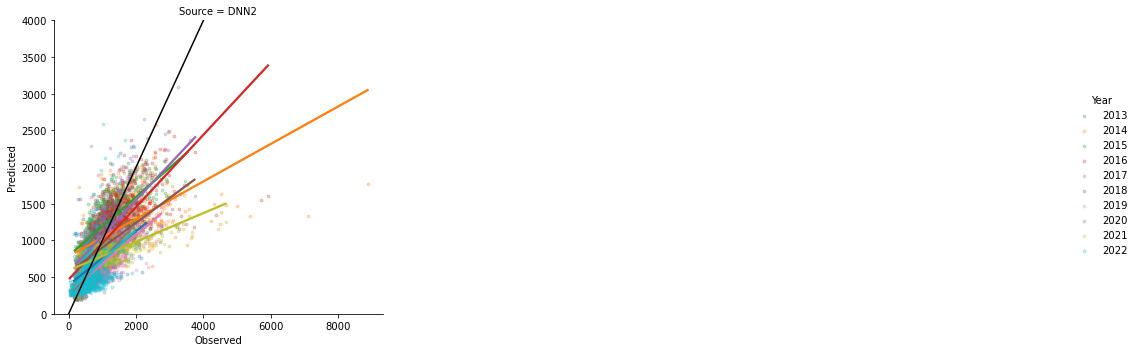

In [77]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)
else:
    p_trans=None

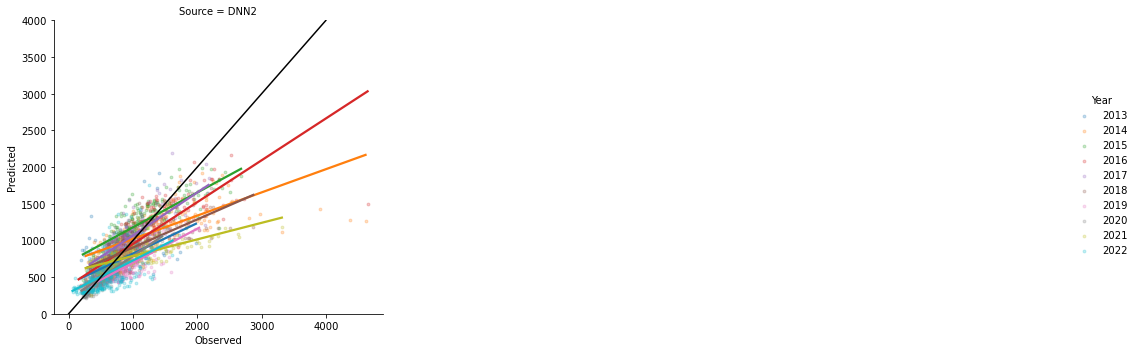

In [78]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

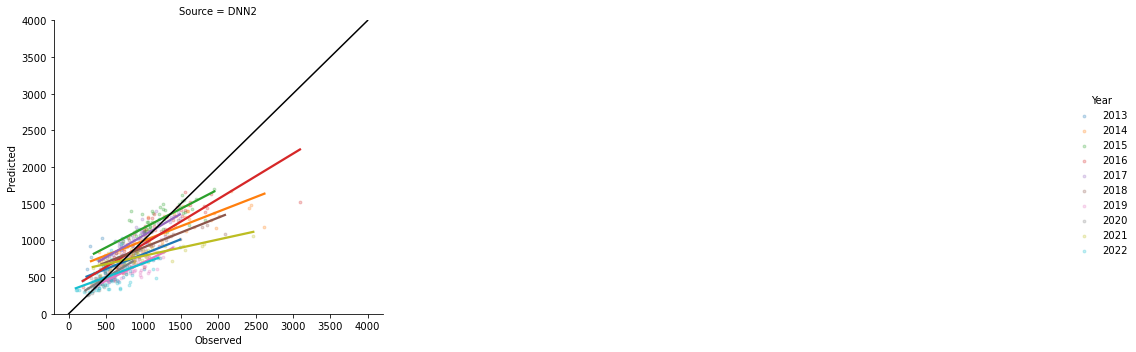

In [79]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [ ]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

In [ ]:
df_lasso_coefs.groupby('Year')['Coef'].count()

In [ ]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip_top, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')

In [ ]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

In [ ]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean_top20,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [66]:
param_dfs = {}
for k in mod_dict:
    if 'OLS' in k:
        continue
    else:
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': yr,
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

In [ ]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_samples', y='MSE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
param_dfs['RF']['max_features'][param_dfs['RF']['max_features'].isnull()] = 'None'
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='ccp_alpha', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

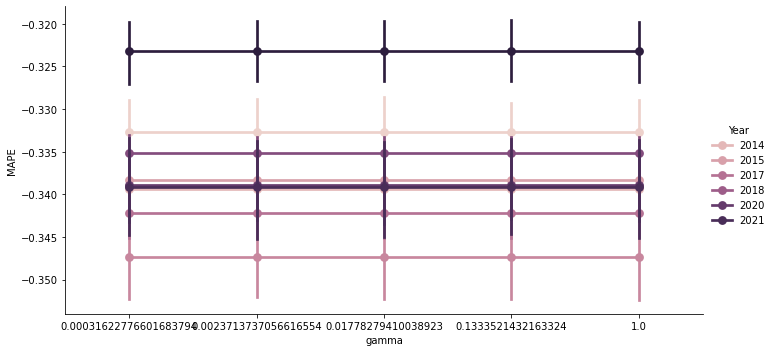

In [67]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

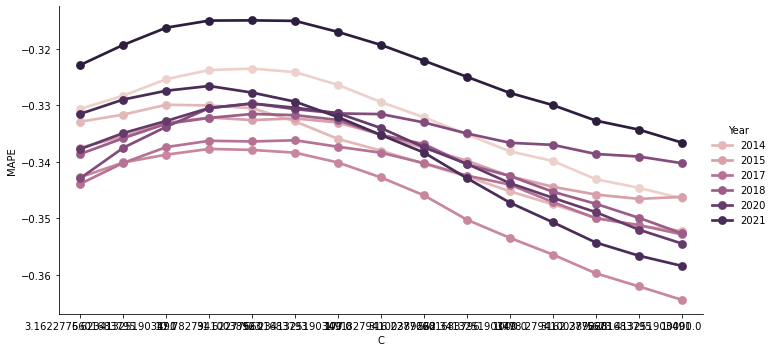

In [68]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

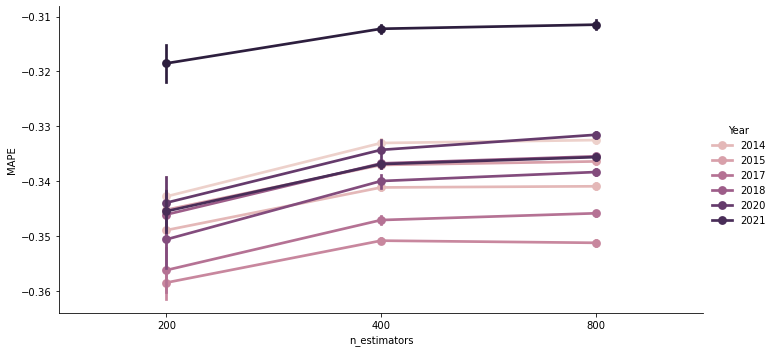

In [69]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)